In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\SUMIT MITRA\anaconda3\envs\tf_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

In [5]:
train_generator = datagen.flow_from_directory(
    'C:/Users/SUMIT MITRA/Final Year Project/cancer/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    'C:/Users/SUMIT MITRA/Final Year Project/cancer/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
    'C:/Users/SUMIT MITRA/Final Year Project/cancer/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4961 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


In [7]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

43941136/43941136 [==============================] - 5s 0us/step


In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=base_model.input, outputs=output)

In [22]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

In [24]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=focal_loss(), metrics=['accuracy'])

In [26]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [28]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping],
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/50
155/155 [==============================] - 289s 2s/step - loss: 0.0809 - accuracy: 0.4995 - lr: 1.0000e-04
Epoch 2/50
155/155 [==============================] - 274s 2s/step - loss: 0.0748 - accuracy: 0.4985 - lr: 1.0000e-04
Epoch 3/50
155/155 [==============================] - 268s 2s/step - loss: 0.0743 - accuracy: 0.4985 - lr: 1.0000e-04
Epoch 4/50
155/155 [==============================] - 254s 2s/step - loss: 0.0735 - accuracy: 0.4993 - lr: 1.0000e-04
Epoch 5/50
155/155 [==============================] - 251s 2s/step - loss: 0.0733 - accuracy: 0.4989 - lr: 1.0000e-04
Epoch 6/50
155/155 [==============================] - 251s 2s/step - loss: 0.0733 - accuracy: 0.4995 - lr: 1.0000e-04
Epoch 7/50
155/155 [==============================] - 251s 2s/step - loss: 0.0728 - accuracy: 0.4997 - lr: 1.0000e-04
Epoch 8/50
155/155 [==============================] - 250s 2s/step - loss: 0.0733 - accuracy: 0.4997 - lr: 1.0000e-04
Epoch 9/50
155/155 [==============================] - 25

In [30]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss(), metrics=['accuracy'])
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
    callbacks=[lr_scheduler, early_stopping],
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/20
155/155 [==============================] - 1211s 8s/step - loss: 0.1356 - accuracy: 0.5421 - lr: 1.0000e-05
Epoch 2/20
155/155 [==============================] - 1199s 8s/step - loss: 0.0852 - accuracy: 0.6379 - lr: 1.0000e-05
Epoch 3/20
155/155 [==============================] - 1198s 8s/step - loss: 0.0553 - accuracy: 0.7296 - lr: 1.0000e-05
Epoch 4/20
155/155 [==============================] - 1194s 8s/step - loss: 0.0389 - accuracy: 0.8073 - lr: 1.0000e-05
Epoch 5/20
155/155 [==============================] - 1186s 8s/step - loss: 0.0283 - accuracy: 0.8570 - lr: 1.0000e-05
Epoch 6/20
155/155 [==============================] - 1215s 8s/step - loss: 0.0220 - accuracy: 0.8975 - lr: 1.0000e-05
Epoch 7/20
155/155 [==============================] - 1213s 8s/step - loss: 0.0154 - accuracy: 0.9257 - lr: 1.0000e-05
Epoch 8/20
155/155 [==============================] - 1212s 8s/step - loss: 0.0131 - accuracy: 0.9412 - lr: 1.0000e-05
Epoch 9/20
155/155 [============================

In [36]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')
val_generator.reset()
val_predictions = (model.predict(val_generator) > 0.5).astype('int32')
val_true_classes = val_generator.classes
val_cm = confusion_matrix(val_true_classes, val_predictions)
print("Validation Confusion Matrix:")
print(val_cm)

40/40 [==============================] - 65s 2s/step - loss: 0.0120 - accuracy: 0.9111
Test accuracy: 0.9111
1/1 [==============================] - 1s 665ms/step
Validation Confusion Matrix:
[[4 0]
 [0 6]]


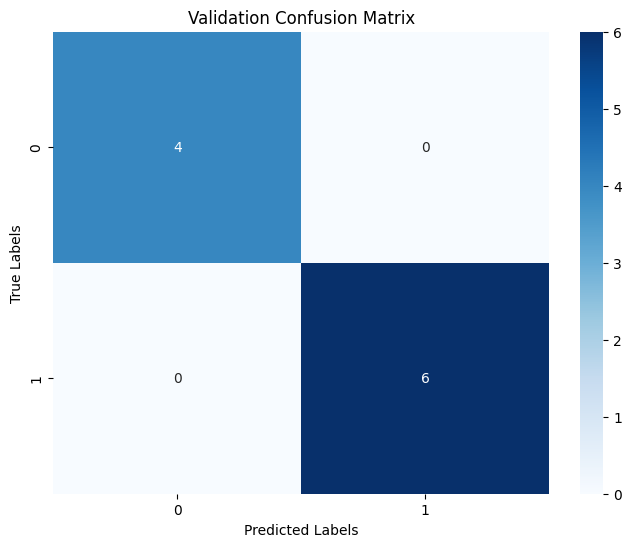

Validation Classification Report:
              precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00         4
      Normal       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

40/40 [==============================] - 64s 2s/step
Test Confusion Matrix:
[[629   0]
 [111 509]]


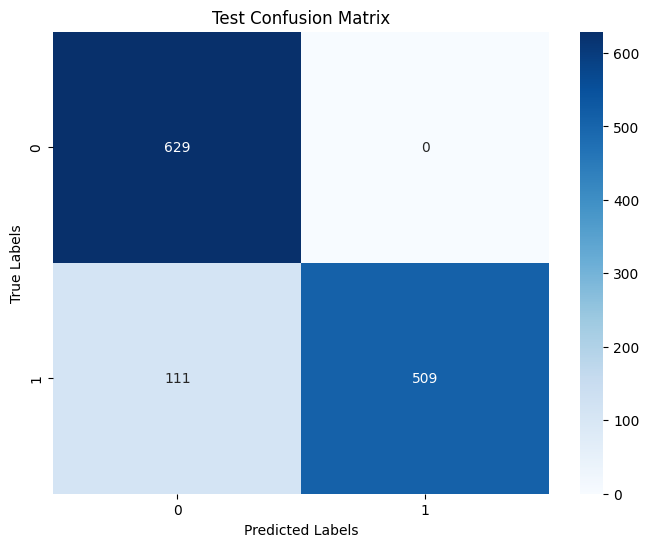

Test Classification Report:
              precision    recall  f1-score   support

      Cancer       0.85      1.00      0.92       629
      Normal       1.00      0.82      0.90       620

    accuracy                           0.91      1249
   macro avg       0.93      0.91      0.91      1249
weighted avg       0.92      0.91      0.91      1249



In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
val_report = classification_report(val_true_classes, val_predictions, target_names=val_generator.class_indices.keys())
print("Validation Classification Report:")
print(val_report)
test_generator.reset()
test_predictions = (model.predict(test_generator) > 0.5).astype('int32')
test_true_classes = test_generator.classes
test_cm = confusion_matrix(test_true_classes, test_predictions)
print("Test Confusion Matrix:")
print(test_cm)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
test_report = classification_report(test_true_classes, test_predictions, target_names=test_generator.class_indices.keys())
print("Test Classification Report:")
print(test_report)

In [60]:
model.save_weights('efficientnet_b3_weights.h5')